In [31]:
def plot_residuals(model):
	fitted = model.fittedvalues
	residuals = model.resid
	standardized_residuals = model.get_influence().resid_studentized_internal

	# Standardized Residuals Plot
	plt.figure(figsize = (8, 6))
	plt.scatter(fitted, standardized_residuals, color = "#1f2db0")
	plt.axhline(0, color = 'red', linestyle = '-')
	plt.axhline(2, color = 'green', linestyle = '--')
	plt.axhline(-2, color = 'green', linestyle = '--')
	plt.xlabel("Predicted y values")
	plt.ylabel("Standardied Residuals")
	plt.title('Standardized Residual Plot')



回歸分析結果摘要：
                                OLS Regression Results                                
Dep. Variable:     flattened_total_box_office   R-squared:                       0.805
Model:                                    OLS   Adj. R-squared:                  0.804
Method:                         Least Squares   F-statistic:                     1449.
Date:                        Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                                21:37:26   Log-Likelihood:                -4676.8
No. Observations:                        3521   AIC:                             9376.
Df Residuals:                            3510   BIC:                             9443.
Df Model:                                  10                                         
Covariance Type:                    nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------

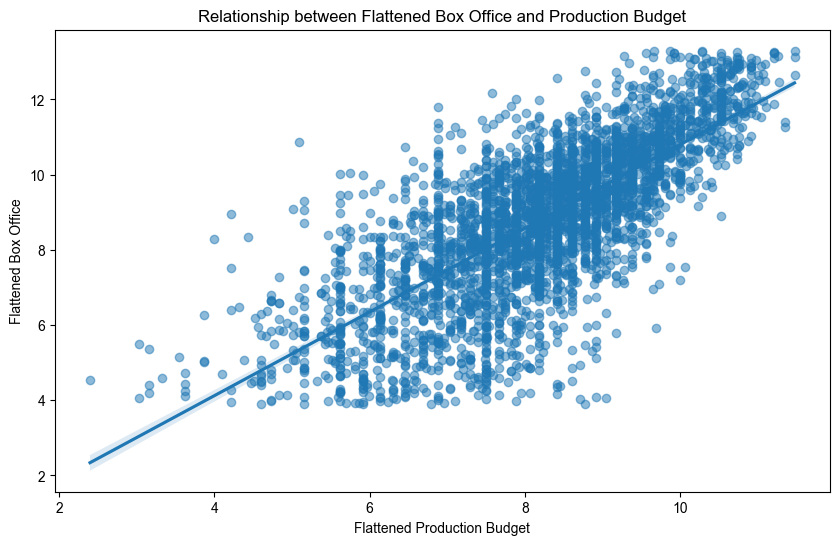

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from scipy import stats
import seaborn as sns
import math

# 設定中文字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 設定支援中文的字型
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.pow(filtered_df["production_budget"], 1/8)
filtered_df["flattened_total_box_office"] = np.pow(filtered_df["total_box_office"], 1/8)
filtered_df["theatrical_engagements"] = np.pow(filtered_df["theatrical_engagements"], 1/2)

filtered_df['z_score'] = stats.zscore(filtered_df['flattened_total_box_office'])
filtered_df = filtered_df[filtered_df['z_score'].abs() <= 2].copy()

# 根據 creative_type 去建立 dummy variable
creative_type_dummy = pd.get_dummies(filtered_df["creative_type"].astype(str), prefix="T")
creative_type_dummy.columns = creative_type_dummy.columns.str.replace(' ', '_')
creative_type_dummy = creative_type_dummy.drop(columns=["T_Dramatization"]) 
filtered_df = pd.concat([filtered_df, creative_type_dummy], axis=1)

# 使用加法模型（Expense ~ TimeIndex + 月份 dummy）
model_formula = "flattened_total_box_office ~ theatrical_engagements + " + " + ".join(creative_type_dummy.columns)

# 執行回歸分析
model = sm.ols(formula=model_formula, data=filtered_df).fit()

# 印出回歸結果摘要
print("\n回歸分析結果摘要：")
print(model.summary())

# 繪製散點圖和回歸線
plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_df, x='flattened_production_budget', y='flattened_total_box_office', scatter_kws={'alpha':0.5})
plt.title('Relationship between Flattened Box Office and Production Budget')
plt.xlabel('Flattened Production Budget')
plt.ylabel('Flattened Box Office')
# 畫出來
plt.show()

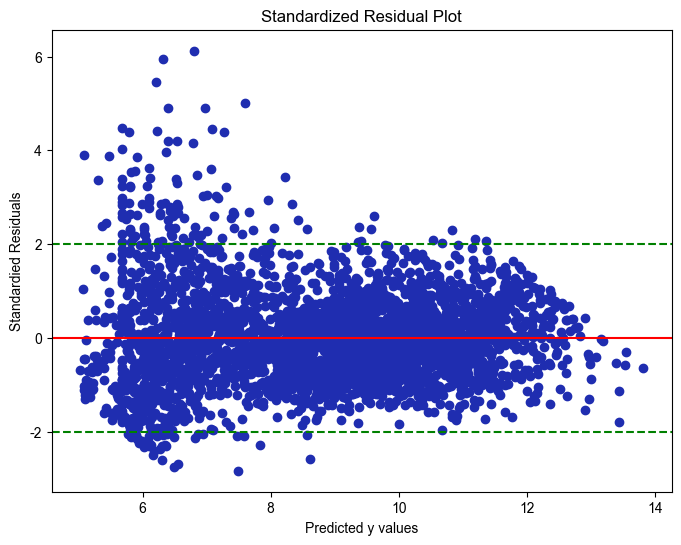

In [33]:
plot_residuals(model)

                                OLS Regression Results                                
Dep. Variable:     flattened_total_box_office   R-squared:                       0.873
Model:                                    OLS   Adj. R-squared:                  0.872
Method:                         Least Squares   F-statistic:                     2232.
Date:                        Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                                21:37:27   Log-Likelihood:                -3514.3
No. Observations:                        3267   AIC:                             7051.
Df Residuals:                            3256   BIC:                             7118.
Df Model:                                  10                                         
Covariance Type:                    nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


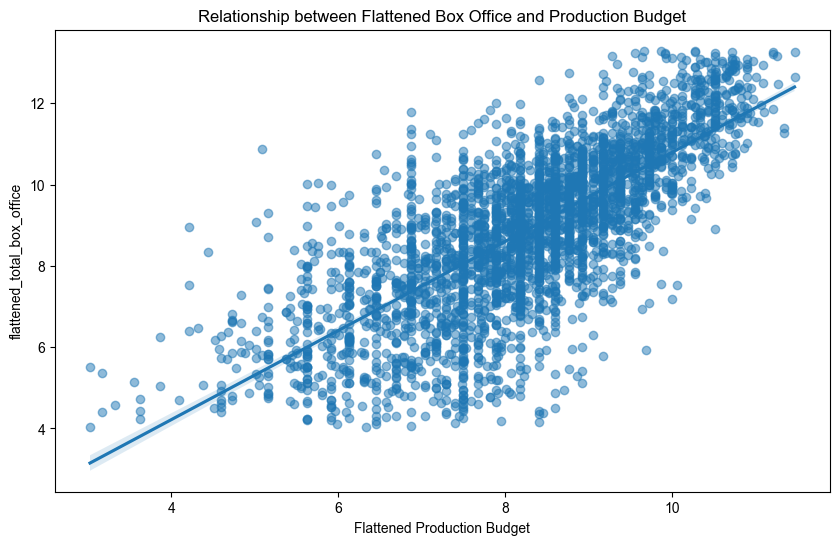

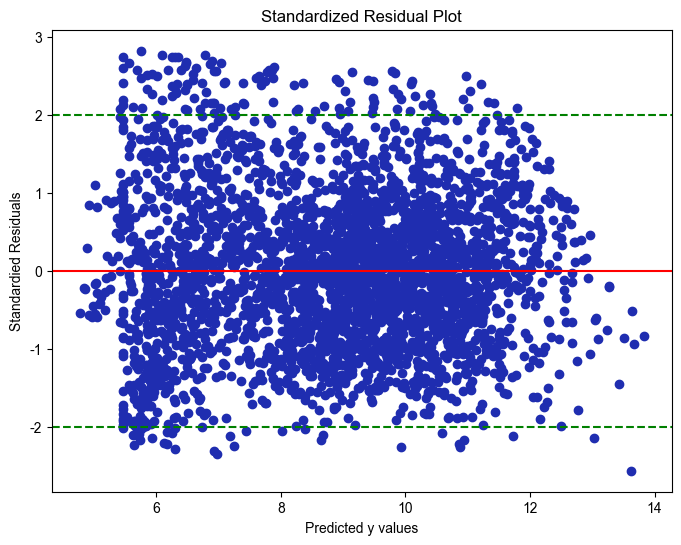

In [34]:
# 去掉殘差與影響值過大的點

# Step 1：取得影響值與殘差
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
standard_resid = influence.resid_studentized_internal

# Step 2：設定門檻
cooks_thresh = 4 / len(filtered_df)
resid_thresh = 2 

# Step 3：留下正常觀測值
mask = (cooks_d < cooks_thresh) & (np.abs(standard_resid) < resid_thresh)
filtered_df = filtered_df[mask].copy()

# Step 4：重新建立模型
model = sm.ols(formula=model_formula, data=filtered_df).fit()
print(model.summary())

# Step 5：繪製殘差圖
plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_df, x='flattened_production_budget', y='flattened_total_box_office', scatter_kws={'alpha':0.5})
plt.title('Relationship between Flattened Box Office and Production Budget')
plt.xlabel('Flattened Production Budget')

plot_residuals(model)   